In [23]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [24]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import search_around_r_data_frames, cross_match_data_frames
import pandas as pd
import numpy as np
import seaborn as sns
import nway_python_api as nway
set_mpl()
%matplotlib inline

matplotlib settings set


In [25]:
erosita = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')

desi =  pd.read_pickle(data_path+'desi_lh.gz_pkl', compression = 'gzip')
desi_matched = cross_match_data_frames(erosita, desi, 'RA_fin', 'DEC_fin', 'ra', 'dec', 30, df_prefix='desi')

xmm_matched = pd.read_pickle(data_path+'xmm_cleared.pkl')

csc = pd.read_pickle(data_path+'csc_cleared.pkl')
csc_matched = cross_match_data_frames(erosita, csc, 'RA_fin', 'DEC_fin', 'ra', 'dec', 30)

ctps = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ctps.ID = ctps.ID.str.decode('utf-8')
ctps.desi_id_true_ctp = ctps.desi_id_true_ctp.str.decode('utf-8')


cross-match radius 30 arcsec
total matches: 135854 out of 9215 x 2418574
	 total unique pairs: 131150
	 total non-unique pairs (duplicates in df2): 4704
cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47


In [26]:
ctps

,ID,desi_id_true_ctp
0,SRGe J103105.9+573747,9011_610714_1440
1,SRGe J103123.8+574309,9011_610714_2092
2,SRGe J103130.8+573932,9011_610714_2412
3,SRGe J103137.0+573159,9011_609939_1093
4,SRGe J103143.5+573156,9011_609939_1343
...,...,...
53,SRGe J105323.6+573829,hostless
54,SRGe J105336.4+573800,hostless
55,SRGe J105506.3+572958,hostless
56,SRGe J105640.4+573203,hostless


In [32]:
def plot_target(eroid, savefig = False):

    df_query = erosita.query("srcname_fin==@eroid")

    ero_ra, ero_dec, ero_err = df_query.iloc[0][['RA_fin', 'DEC_fin', 'pos_r98']]

    search_rad = ero_err*1.5
    fig, ax = plt.subplots(figsize=(10, 10))

    csc_around = csc_matched.query("srcname_fin	== @eroid & sep<@search_rad")
    if len(csc_around) == 0:
        pass
        #print('No CSC')
    else:
        for row in csc_around.itertuples():
            ra, dec, err = row.ra, row.dec, row.r_98_csc
            ra = 3600*(ra - ero_ra)
            dec = 3600*(dec - ero_dec)
            circle = plt.Circle((ra, dec), err, color='b', fill=False, label = 'CSC')
            ax.add_artist(circle)
            circle = plt.Circle((ra, dec), 1.43, color='b', fill=False,  linestyle='dashed', alpha = 0.4)
            ax.add_artist(circle)
            


    xmm_around = xmm_matched.query("srcname_fin	== @eroid & Separation<@search_rad")
    if len(xmm_around) == 0:
        #print('No XMM')
        pass
    else:
        for row in xmm_around.itertuples():
            ra, dec, err = row.SC_RA, row.SC_DEC, row.xmm_pos_r98
            ra = 3600*(ra - ero_ra)
            dec = 3600*(dec - ero_dec)
            circle = plt.Circle((ra, dec), err, color='c', fill=False, label = 'XMM')
            ax.add_artist(circle)
            circle = plt.Circle((ra, dec), 1.43, color='c', fill=False,  linestyle='dashed', alpha = 0.4)
            ax.add_artist(circle)



    desi_around = desi_matched.query("srcname_fin == @eroid & desi_sep<@search_rad")
    if len(desi_around) == 0:
        pass
        #print('No DESI')
    else:
        for row in desi_around.itertuples():
            ra, dec, err = row.desi_ra, row.desi_dec, 0.25
            ra = 3600*(ra - ero_ra)
            dec = 3600*(dec - ero_dec)
            circle = plt.Circle((ra, dec), err, color='g', fill=False, label = '_DESI')
            ax.add_artist(circle)
            ax.text(ra, dec, row.desi_desi_id, color='g', fontsize=12)

    circle = plt.Circle((0, 0), ero_err, color='r', fill=False, label = 'eRO')
    ax.add_artist(circle)

    axislim = 3*ero_err

    ax.set_xlim(-axislim, axislim)
    ax.set_ylim(-axislim, axislim)

    ax.set_xlabel('delta RA, arcsec')
    ax.set_ylabel('delta DEC, arcsec')
    ax.legend()

    try:
        true_ctps = ctps.query("ID==@eroid").iloc[0].desi_id_true_ctp   
    except:
        true_ctps = 'unknown'

    title = eroid + '|'+  true_ctps
    ax.set_title(title)
    if savefig:
        plt.savefig('plots/'+eroid.replace(' ','')+'_'+true_ctps+'.png', dpi=300)


# plot_target('SRGe J103118.8+574434')
# plot_target('SRGe J103130.8+573932') #nice example!
# plot_target('SRGe J110721.3+590113')


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_53406/965982834.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eroid in tqdm(ctps.query('desi_id_true_ctp!="hostless"').sample(10).ID):


  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_53406/965982834.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eroid in tqdm(ctps.query('desi_id_true_ctp=="hostless"').sample(3).ID):


  0%|          | 0/3 [00:00<?, ?it/s]

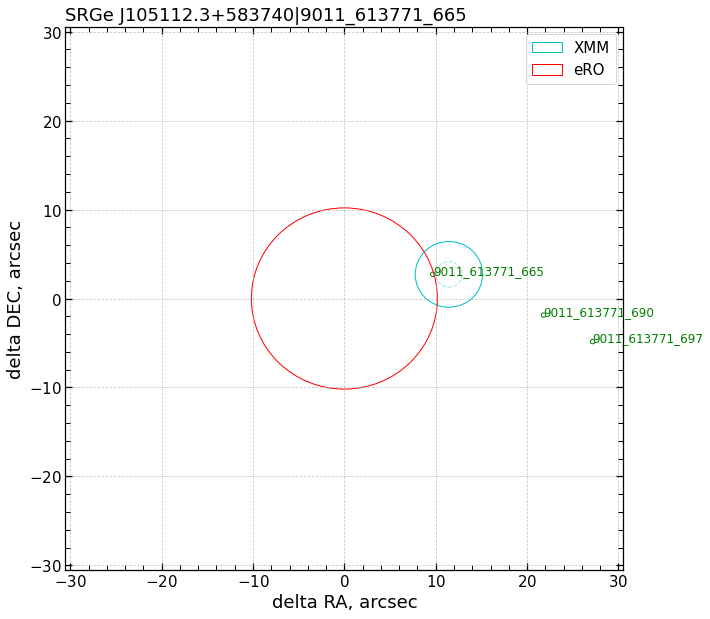

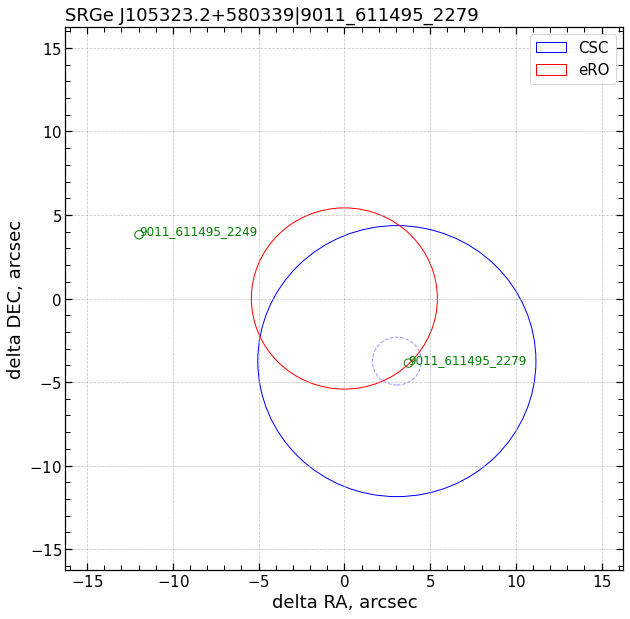

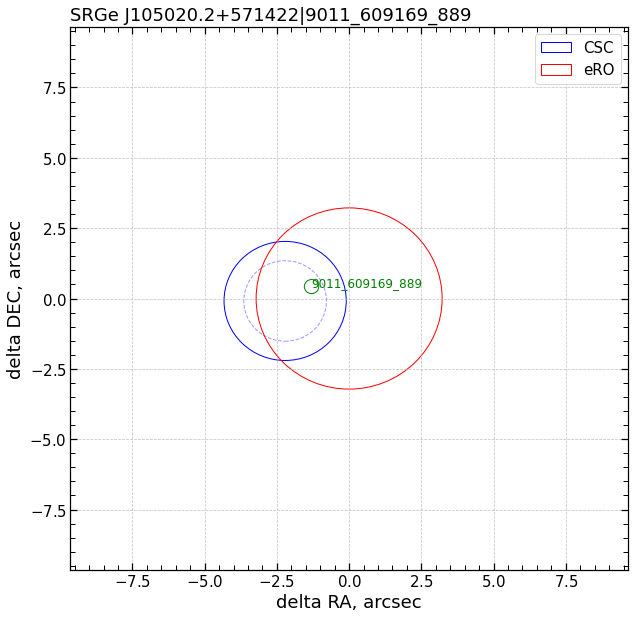

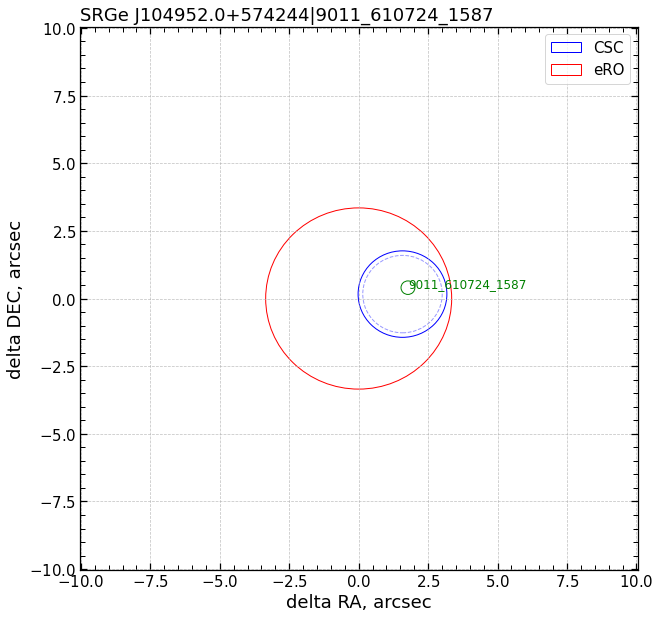

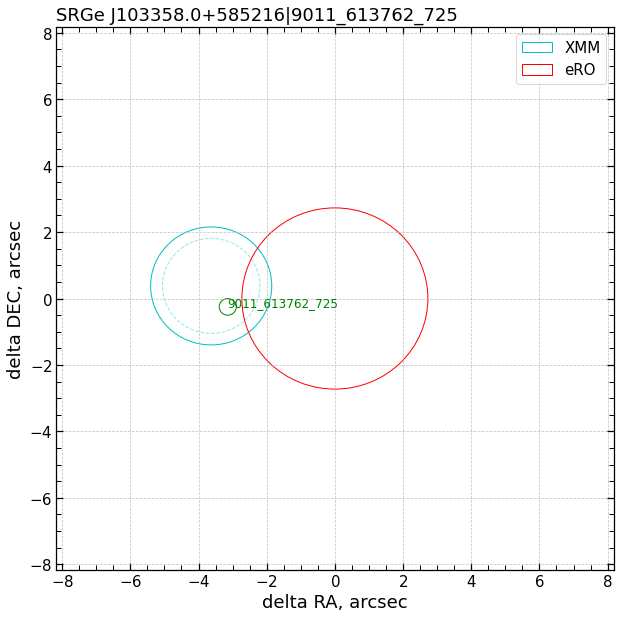

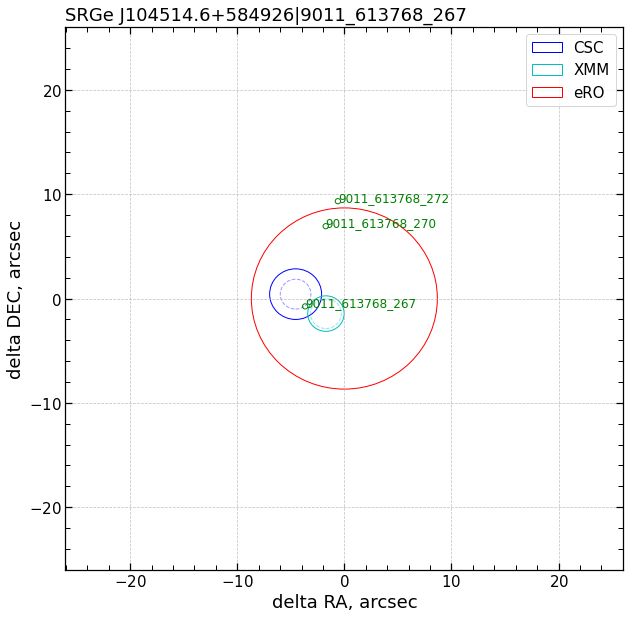

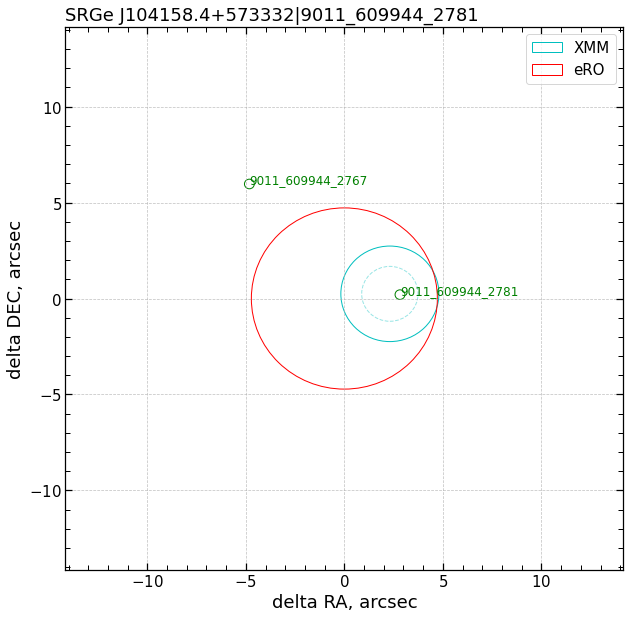

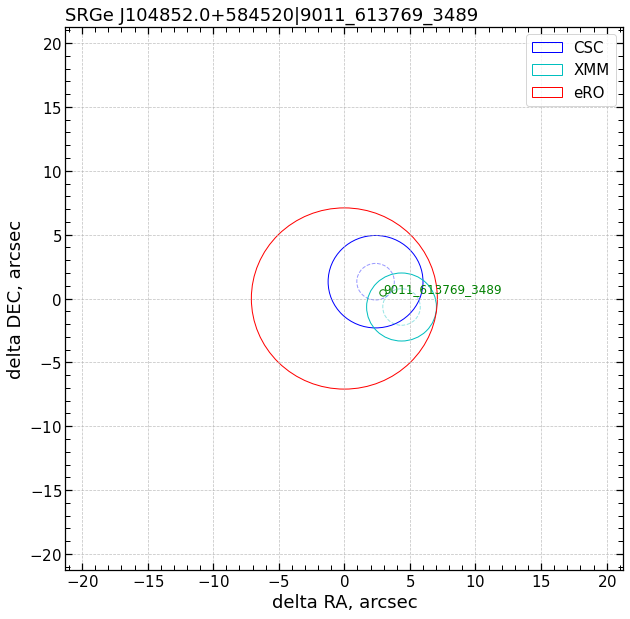

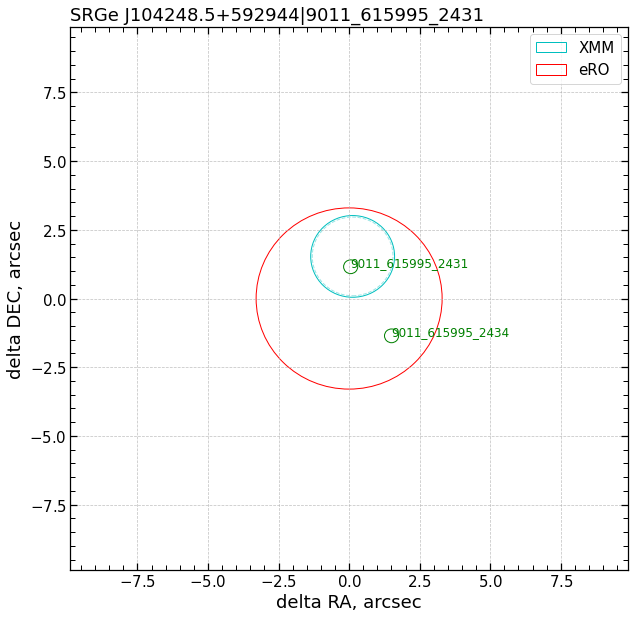

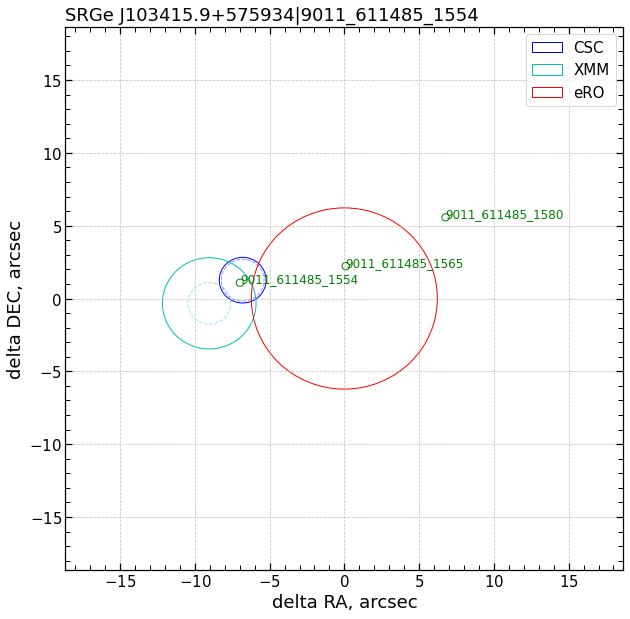

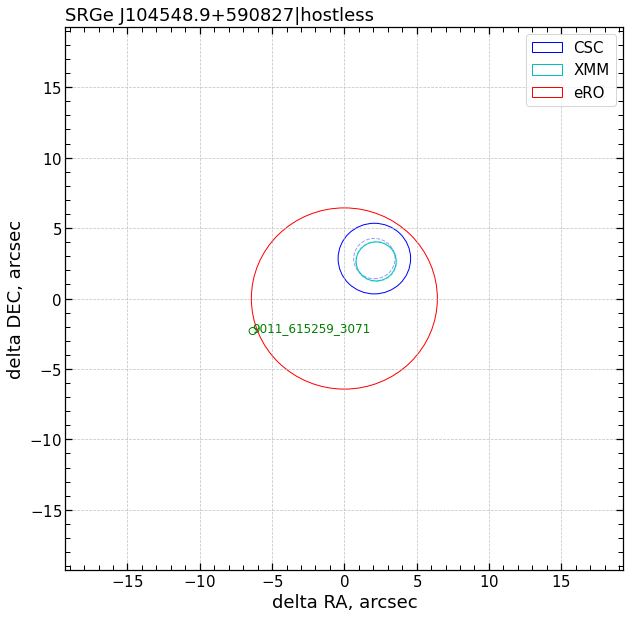

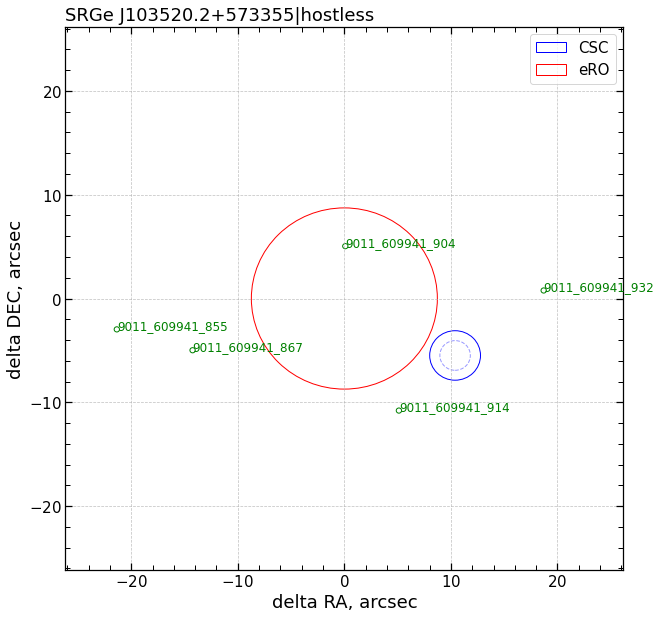

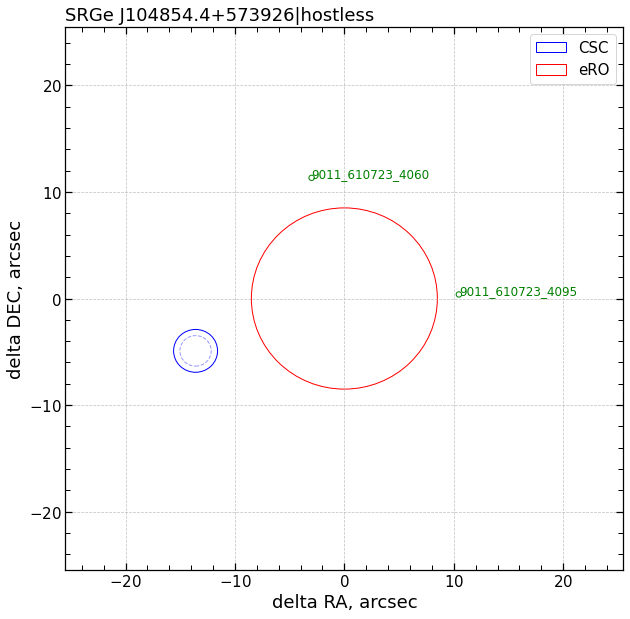

In [34]:
from tqdm import tqdm_notebook as tqdm
for eroid in tqdm(ctps.query('desi_id_true_ctp!="hostless"').sample(10).ID):
    plot_target(eroid, savefig = True)

for eroid in tqdm(ctps.query('desi_id_true_ctp=="hostless"').sample(3).ID):
    plot_target(eroid, savefig = True)


In [29]:
# from tqdm import tqdm_notebook as tqdm
# for eroid in tqdm(ctps.query('desi_id_true_ctp=="hostless"').ID):
#     plot_target(eroid, savefig=True)
#     plt.close('all')


/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_53406/2200910425.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for eroid in tqdm(ctps.query('desi_id_true_ctp=="hostless"').ID):


  0%|          | 0/54 [00:00<?, ?it/s]